In [3]:
!pipreqsnb --force ./

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\bswat\anaconda3\Scripts\pipreqsnb.exe\__main__.py", line 7, in <module>
  File "C:\Users\bswat\anaconda3\Lib\site-packages\pipreqsnb\pipreqsnb.py", line 120, in main
    nb = json.load(open(nb_file, 'r', **open_file_args))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bswat\anaconda3\Lib\json\__init__.py", line 293, in load
    return loads(fp.read(),
                 ^^^^^^^^^
  File "C:\Users\bswat\anaconda3\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 20887: character maps to <undefined>


In [7]:
# pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [283]:
import pandas as pd
import numpy as np
import joblib
import fasttext
import fasttext.util
from scipy.linalg import orthogonal_procrustes
from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Data Preparation

## Loading data : English to Hindi translation pairs from the MUSE dataset by Meta.

In [2]:
train_path = "data/train.txt"
test_path = "data/test.txt"
data_path = "data/en-hi.txt"

We are loading the text pairs into a pandas dataframe for easy access. Reading with Pandas was chosen over directly loading from the file as the system could not recognise the Devanagri script if loaded directly and was throwing errors. 

<!-- Separate train and test files were downloaded from the github repository and loaded accordingly. The train dataset contains 8704 text pairs and the test set has 2032 pairs. Sample of the dataset is also shown. Each entity of the dataframe is a string. The dataframes are then converted to dictionaries for ease of access. -->

The entire dataset contains 38216 pairs of english-hindi translations. 80% of the data is to be used for training and the rest 20% for testing.

In [5]:
data_df = pd.read_csv(data_path, sep = '\t', header = None)
data_df = data_df.dropna()
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38216 entries, 0 to 38220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       38216 non-null  object
 1   1       38216 non-null  object
dtypes: object(2)
memory usage: 895.7+ KB


In [7]:
train_df = data_df.loc[:len(data_df)*0.8]
test_df = data_df.loc[len(data_df)*0.8:]

print("Train Data Info", train_df.info())
print("Test Data Info", test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30568 entries, 0 to 30572
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       30568 non-null  object
 1   1       30568 non-null  object
dtypes: object(2)
memory usage: 716.4+ KB
Train Data Info None
<class 'pandas.core.frame.DataFrame'>
Index: 7648 entries, 30573 to 38220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7648 non-null   object
 1   1       7648 non-null   object
dtypes: object(2)
memory usage: 179.2+ KB
Test Data Info None


In [553]:
# train_df = pd.read_csv(train_path, sep = '\t', header = None)
# print(train_df.info())

# test_df = pd.read_csv(test_path, sep = '\t', header = None)
# print(test_df.info())

In [9]:
train_df.head()

,0,1
0,and,और
1,was,था
2,was,थी
3,for,लिये
4,that,उस


## Loading pre-trained Fasttext monolingual embeddings

To get the word vectors for different words in both Hindi and English, the embedding models are downloaded from [here](https://fasttext.cc/docs/en/pretrained-vectors.html). The word vectors for all the words from the dataset, both the train and test sets, are generated and stored for future references in two separate lists.

In [11]:
### These are not being passed to the models and being treated as global variables

hindi_embed = fasttext.load_model('Embeddings/wiki.hi.bin')     ### Embedding model for Hindi words
english_embed = fasttext.load_model('Embeddings/wiki.en.bin')   ### Embedding model for English words

In [12]:
english_words = list(train_df[0]) + list(test_df[0])            ### All the English words in corpus
hindi_words = list(train_df[1]) + list(test_df[1])              ### All the Hindi words in the corpus

In [17]:
print(len(english_words), len(hindi_words))

38216 38216


In [48]:
### Use of dictionaries is discarded to preserve the duplicate entries
# english_vectors = {word : english_embed.get_word_vector(word) for word in english_words}
# hindi_vectors = {word: hindi_embed.get_word_vector(word) for word in hindi_words}    

In [13]:
### To load the word vectors. To create the embedding word vectors from scratch, run the commented out lines in this cell

english_vectors = joblib.load("vars/english_vectors")
hindi_vectors = joblib.load("vars/hindi_vectors")

# english_vectors = [english_embed.get_word_vector(word) for word in english_words]
# hindi_vectors = [hindi_embed.get_word_vector(word) for word in hindi_words]

In [46]:
### To store the list of word vectors

# joblib.dump(english_vectors, "vars/english_vectors")
# joblib.dump(hindi_vectors, "vars/hindi_vectors")

In [37]:
### Dimension of embeddings

dim = len(list(english_vectors)[0])
dim

300

# Embedding Alignment: Applying orthogonal Procrustes method

For the calculation of the solution of the Procrustes alignment, the train set containing embedding word vectors is constructed into matrices of dimensions (*numSamples , dimension of embedding*), i.e. (8704, 300) for our case here.

The Procrustes method utilises Singular Value Decomposition to compute the best transformation to align the source matrix to the target matrix. Once the solution **W** is computed, the transformation is applied to the embedding of an English word ($s_e$) to get a resulting transformed vector ($W \cdot s_e$). According to [Conneau et al.](https://arxiv.org/pdf/1710.04087), the corresponding word from the resulting embedding is given by the Hindi word ($h$), whose embedding has the highest cosine similarity with the transformed source vector embedding.

$$
t = \arg\max_t \cos(W \cdot x_s, y_t)
$$


In [15]:
def createMatrices(n, english_vectors, hindi_vectors):
    english_matrix = np.empty((0, dim))
    hindi_matrix = np.empty((0, dim))
    
    for i in range(n):
        english_matrix = np.vstack([english_matrix, english_vectors[i].reshape((1, 300))])
        hindi_matrix = np.vstack([hindi_matrix, hindi_vectors[i].reshape((1, 300))])

    return english_matrix, hindi_matrix

In [16]:
### To save computation time, precomputed matrices are stored for ease of execution. To recompute the matrices, line commented below

# english_matrix, hindi_matrix = createMatrices(len(train_data), english_vectors, hindi_vectors)

english_matrix = joblib.load("vars/english_matrix")
hindi_matrix = joblib.load("vars/hindi_matrix")

In [20]:
### Code to store the variables

# joblib.dump(english_matrix, "vars/english_matrix")
# joblib.dump(hindi_matrix, "vars/hindi_matrix")

In [17]:
english_matrix.shape, hindi_matrix.shape

((30568, 300), (30568, 300))

In [18]:
# A = hindi_matrix @ (english_matrix.T)
# U, s, V = svd(A, full_matrices=0)
# R = U @ V.T
# W = np.multiply((1 + 0.01), R) - np.multiply(0.01, R @ R.T) @ R

#### The above is the exact implementation of the code from the paper. However due to the large sizes of the English and Hindi matrices, the SVD 
#### was not being performed

W, A = orthogonal_procrustes(english_matrix, hindi_matrix)

In [19]:
W.shape

(300, 300)

# Evaluation

## Creating the store of transformed embeddings of the source word

In [30]:
def transformSource(english_word, R):
    english_vector = english_embed.get_word_vector(english_word)
    return np.dot(english_vector, R)

In [32]:
transformed_vectors = []

for word in english_words:
    transformed_vectors.append(transformSource(word, W))

## Function for translating English words to Hindi

The function takes in the English word to be translated, the transformation matrix from the Procrustes problem with orthogonality, the model which converts English words to their corresponding word vector and all the Hindi word vectors, to return the Hindi translation of the English word.

In [104]:
def translateWord(english_word, R, hindi_vectors):        
    translation_vector = transformSource(english_word, R)
    i = max(np.arange(0, len(hindi_vectors)-1), key=lambda i: np.dot(hindi_vectors[i], translation_vector))
    
    return hindi_words[i]

In [106]:
translateWord('november', W, hindi_vectors) ### The translation is not very accurate

'फ़रवरी'

In [180]:
def calAccuracy(df, W):
    
    hindi_translated = []
    
    for word in df[0]:
        t = translateWord(word, W, hindi_vectors)
        hindi_translated.append(t)
        
    trueHindi = list(df[1])
    preds = []
    
    for i in range(len(trueHindi)):
        if trueHindi[i] == hindi_translated[i]:
            preds.append(1)
        else:
            preds.append(0)
            
    return (sum(preds)/len(preds))

## Accuracy calculation

In [594]:
trainAcc = calAccuracy(train_df, W)
testAcc = calAccuracy(test_df, W)

print("The accuracy of translation by the model on the training set is {:.4f}".format(trainAcc))
print("The accuracy of translation by the model on the test set is {:.4f}".format(testAcc))

The accuracy of translation by the model on the training set is 0.1273
The accuracy of translation by the model on the test set is 0.0088


## Precision@k

Precsion@k metric counts the number of true predictions in the top 'k' predicted words as translations for the given word. We are interested in Precision@1 and Precision@5 metrics. Precision@1 could also be considered as accuracy as we are considering the top 1 prediction as the translation. The computation of Precision@5 is done below.

In [108]:
def topTranslateWords(english_word, R, hindi_vectors, k):        

    translation_vector = transformSource(english_word, R)
    indices = sorted(np.arange(0, len(hindi_vectors)-1), key=lambda i: np.dot(hindi_vectors[i], translation_vector), reverse = True)[:k]
    
    return [hindi_words[i] for i in indices]

In [110]:
topTranslateWords('november', W, hindi_vectors, 5)     #### the dataset is not perfect and has english words as hindi translations

['फ़रवरी', 'फ़रवरी', 'नवम्बर', 'नवम्बर', 'दिसम्बर']

In [178]:
def calPrecision(df, W, k):
    topAns = []
    
    for word in df[0]:
        t = topTranslateWords(word, W, english_embed, hindi_vectors, k)
        topAns.append(t)
        
    trueHindi = list(df[1])
    preds = []
    
    for i in range(len(trueHindi)):
        if trueHindi[i] in topAns[i]:
            preds.append(1)
        else:
            preds.append(0)
            
    return (sum(preds)/len(preds))

In [60]:
trainAcc = calPrecision(train_df, W, 5)
testAcc = calPrecision(test_df,W, 5)

print("The accuracy of translation by the model on the training set is {:.4f}".format(trainAcc))
print("The accuracy of translation by the model on the test set is {:.4f}".format(testAcc))

The accuracy of translation by the model on the training set is 0.2575
The accuracy of translation by the model on the test set is 0.0395


The precision@5 in translation is much better for previously seen words than the unseen words

## Studying the cosine similarities

The semantic similarities of the pairs of words are studied using cosine similarity. To understand the effect of the alignment, the similarities are compared before and after alignment. The results are visualized as histograms.

In [129]:
## Cosine Similarities of word pairs before alignment

before_similarities = []

for e, h in zip(english_vectors, hindi_vectors):
    before_similarities.append(cosine_similarity([e],[h])[0][0])

In [130]:
## Cosine similarities of word pairs after alignment

after_similarities = []

for e, h in zip(transformed_vectors, hindi_vectors):
    after_similarities.append(cosine_similarity([e],[h])[0][0])

[Text(0.5, 0, 'Cosine Similarity'), Text(0, 0.5, 'Frequency')]

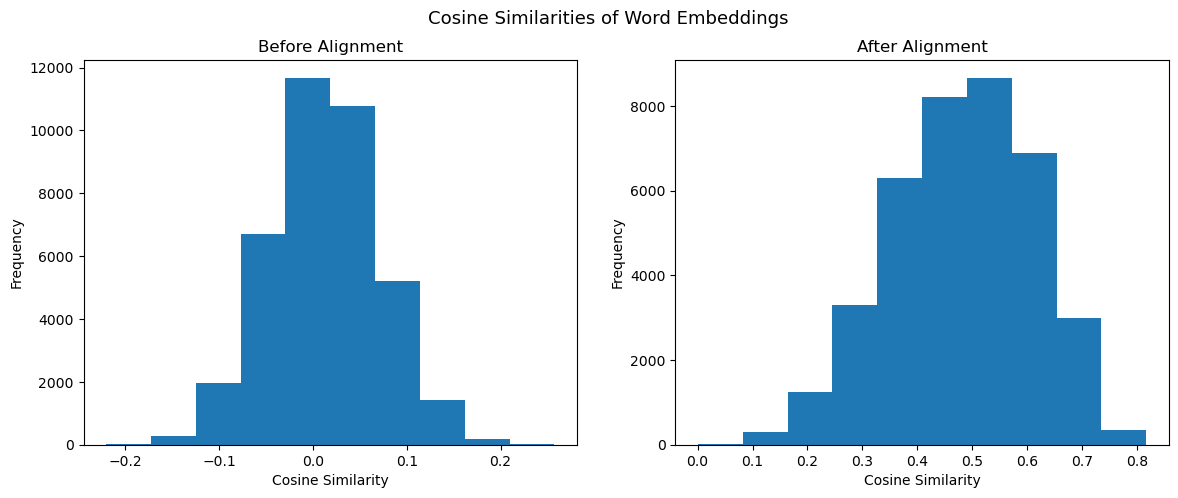

In [158]:
## Plotting the histograms

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Cosine Similarities of Word Embeddings', fontsize = 13)
ax1.set_title("Before Alignment")
ax1.hist(before_similarities)
ax1.set(xlabel = 'Cosine Similarity', ylabel = "Frequency")
ax2.set_title("After Alignment")
ax2.hist(after_similarities)
ax2.set(xlabel = 'Cosine Similarity', ylabel = "Frequency")

In [151]:
print("After Alignment, the mean cosine similarity of vectors improve from {:.4f} to {:.4f}".format(np.mean(before_similarities), np.mean(after_similarities)))

After Alignment, the mean cosine similarity of vectors improve from 0.0129 to 0.4812


## Ablation Study : Effect of Training set size

To understand the perfomance of the number of pairs used in the alignment, datasets of different sizes are used for alignment and the accuracy is compared on the train set and the common test set. There are a total of 30568 pairs in the originally defined training set. Datasets of different sizes, starting from 5% of the training set till the entire set are to be studied.

In [196]:
### Function encompassing all the required tasks to implement cross-lingual translation

def CrossLangTranslate(train_df, test_df):

    english_vectors = [english_embed.get_word_vector(word) for word in train_df[0]]
    hindi_vectors = [hindi_embed.get_word_vector(word) for word in train_df[1]]
    W, A = orthogonal_procrustes(english_vectors, hindi_vectors)

    trainAcc = calAccuracy(train_df, W)
    testAcc = calAccuracy(test_df, W)

    return (trainAcc, testAcc)

In [192]:
### The percentage of datasets to be compared are 5, 10, 20, 35, 50, 65, 80, 100

n = len(train_df)
sizes = [int(n*0.05), int(n*0.1), int(n*0.2), int(n*0.35), int(n*0.5), int(n*0.65), int(n*0.80), int(n)]

In [202]:
accuracies = []

for s in sizes:
    accuracies.append(CrossLangTranslate(train_df.loc[:s], test_df))

In [214]:
# joblib.dump(accuracies, 'vars/accuracies')

# accuracies = joblib.load('vars/accuracies')

In [251]:
train_accuracies = [acc[0] for acc in accuracies]
test_accuracies = [acc[1] for acc in accuracies]

for ele in accuracies:
    print(ele)

(0.3296272073250491, 0.004968619246861925)
(0.3169774288518155, 0.004968619246861925)
(0.29800457965325483, 0.007191422594142259)
(0.26918403589120476, 0.008106694560669456)
(0.22787958115183246, 0.007583682008368201)
(0.18927762396174175, 0.00653765690376569)
(0.15926380368098159, 0.007322175732217573)
(0.12733935348776337, 0.008760460251046025)


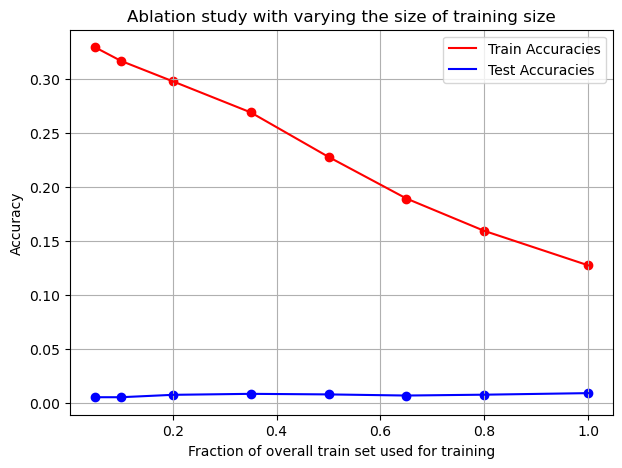

In [243]:
x = [0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 1]

plt.figure(figsize = (7, 5))
plt.title('Ablation study with varying the size of training size')
plt.grid()
plt.scatter(x, train_accuracies, c = 'r')
plt.plot(x, train_accuracies, c = 'r', label = 'Train Accuracies')
plt.scatter(x, test_accuracies, c = 'b')
plt.plot(x, test_accuracies, c = 'b', label = 'Test Accuracies')
plt.xlabel('Fraction of overall train set used for training')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above plot, we can see that the training accuracy decreases with the increase in the number of word pairs used in alignment. This is because, the increase in the number of words makes it difficult to find the accurate transformation to produce the correct translation. 

For the test set, the accuracy constantly remains below 1%. But there is a slight improvement in the translation from increasing the number of word pairs from 10% to 20% of the overall training set size. This could be because of the marginal increase in generalizability for unseen words. Overall, the accuracies are not great for previously unseen words.

Even though orthogonal Procrustus alignment gives okayish results, this further could be improved by the implementation of neural methods to map the translations.